Project Part III

Diversity in recommendations ensures that users are exposed to a wide range of content. Moreover, diversity in sequential group recommendation systems is particularly important since it helps prevent the reinforcement of biases that may arise from repeated exposure to similar types of content. For example, in a system where recommendations are based solely on past behaviour, there is a risk that users will only be exposed to content that aligns with their previous interactions, thus limiting their exposure to new movies. 

In Part III of the project, we would like to promote diversity in recommender systems to offer a wide range of content and ensure that this content is relevant and engaging for
all members of the group. Motivated by the diversification methods we discussed in class, design (7 points) and implement (7 points) a new method for producing diverse sequential group recommendations. Explain why this method works well for the case of sequential group recommendations (6 points). Prepare also a short presentation (about 5 slides) to show how your method works (5 points).

In [15]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score
from scipy.spatial.distance import pdist, squareform
from itertools import combinations


In [16]:
links = pd.read_csv('ml-latest-small/links.csv')
movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')
tags = pd.read_csv('ml-latest-small/tags.csv')

print("Links Dataset:")
display(links.head())

print("\nMovies Dataset:")
display(movies.head())

print("\nRatings Dataset:")
display(ratings.head())

print("\nTags Dataset:")
display(tags.head())

rating_count = ratings.shape[0]
print(f"\nTotal number of ratings: {rating_count}")

Links Dataset:


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0



Movies Dataset:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy



Ratings Dataset:


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931



Tags Dataset:


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200



Total number of ratings: 100836


Selected group users based on the most ratings: [599, 474, 448, 271, 610]

Iteration 1:
User 599 recommendations: ["Schindler's List (1993)", 'Finding Nemo (2003)', "One Flew Over the Cuckoo's Nest (1975)", 'Dances with Wolves (1990)', 'Babe (1995)']
User 474 recommendations: ['Dark Knight, The (2008)', 'Fifth Element, The (1997)', 'Inception (2010)', 'GoldenEye (1995)', 'Die Hard: With a Vengeance (1995)']
User 448 recommendations: ['Shawshank Redemption, The (1994)', 'Braveheart (1995)', 'Saving Private Ryan (1998)', "Schindler's List (1993)", 'Shrek (2001)']
User 271 recommendations: ['Matrix, The (1999)', 'Pulp Fiction (1994)', 'Star Wars: Episode IV - A New Hope (1977)', 'Shawshank Redemption, The (1994)', 'Star Wars: Episode V - The Empire Strikes Back (1980)']
User 610 recommendations: ['Good Will Hunting (1997)', 'American History X (1998)', 'Lion King, The (1994)', 'Men in Black (a.k.a. MIB) (1997)', "One Flew Over the Cuckoo's Nest (1975)"]
Group recommendations: ["Schindler'

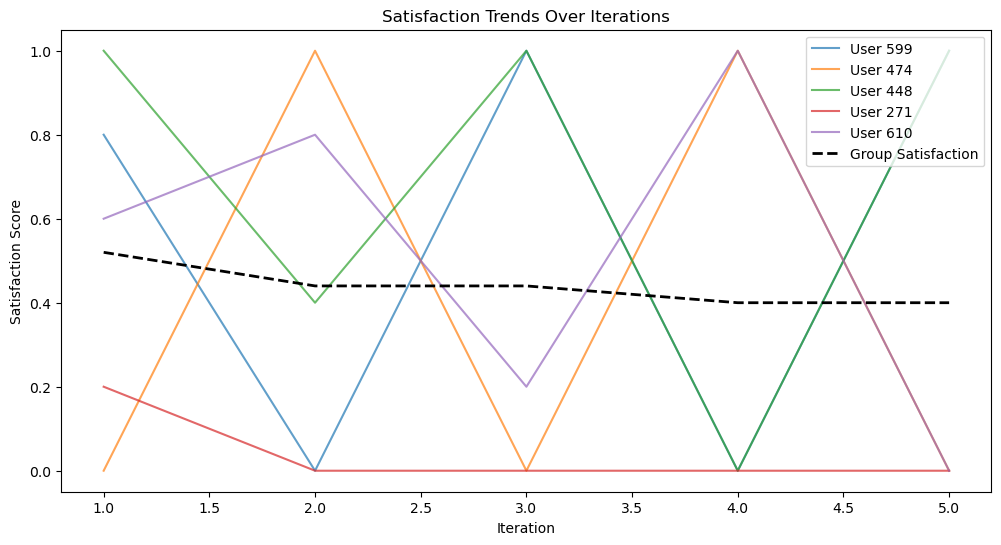

In [18]:
# User-item matrix for cosine similarity
user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)

similarity_matrix = cosine_similarity(user_item_matrix)
similarity_df = pd.DataFrame(similarity_matrix, index=user_item_matrix.index, columns=user_item_matrix.index)

# Compute the number of ratings per user
user_ratings_count = ratings.groupby('userId').size()

# Select the top 5 users with the most ratings
top_users = user_ratings_count.nlargest(6).index.tolist()
group_users = [599, 474, 448, 271, 610]

print(f"Selected group users based on the most ratings: {group_users}")

# Satisfaction scores for the users (initially all unsatisfied)
satisfaction_scores = {user: 0.0 for user in group_users}

# Keep track of movies already recommended for each user and group
user_history = {user: set() for user in group_users}
group_history = set()

# Keep track of satisfaction trends
satisfaction_trends = {user: [] for user in group_users}
# Assume `movies` dataset includes features for movies
# Example: Movie features for similarity (e.g., genre vectors)
movie_features = {row['movieId']: np.random.rand(10) for _, row in movies.iterrows()}  # Replace with real features


# Function to get movie names
def get_movie_title(movie_id):
    title = movies[movies['movieId'] == movie_id]['title']
    return title.values[0] if not title.empty else "Unknown"

# Function to apply fairness-aware weights
def capped_weights(weights, cap=2.0):
    return {user: min(weight, cap) for user, weight in weights.items()}

# Function to recommend for a user based on similarity
def recommend_for_user(user_id, user_item_matrix, similarity_df, num_recommendations=5):
    similar_users = similarity_df[user_id].sort_values(ascending=False)
    user_rated_movies = user_item_matrix.loc[user_id]
    watched_movies = set(user_rated_movies[user_rated_movies > 0].index)
    scores = pd.Series(dtype=np.float64)
    
    for similar_user, similarity_score in similar_users.items():
        if similar_user == user_id:
            continue
        weighted_ratings = user_item_matrix.loc[similar_user] * similarity_score
        scores = scores.add(weighted_ratings, fill_value=0)
    
    scores = scores[~scores.index.isin(watched_movies | user_history[user_id] | group_history)]

    # Genre-matching adjustment
    user_ratings = ratings[ratings['userId'] == user_id]
    high_rated_movies = user_ratings[user_ratings['rating'] >= 4.0]['movieId']
    high_rated_genres = movies[movies['movieId'].isin(high_rated_movies)]['genres']
    user_genres = set([genre for genres in high_rated_genres for genre in genres.split('|')])
    
    for movie_id in scores.index:
        movie_genres = set(movies[movies['movieId'] == movie_id]['genres'].values[0].split('|'))
        genre_match = len(user_genres & movie_genres)
        scores[movie_id] += genre_match * 0.1

    recommended_movies = scores.sort_values(ascending=False).head(num_recommendations)
    user_history[user_id].update(recommended_movies.index)
    return [(movie_id, score) for movie_id, score in recommended_movies.items()]

# Maximal Marginal Relevance (MMR) for diversity
def maximal_marginal_relevance(candidate_movies, group_history, lambda_param=0.5, k=10):
    selected_movies = []
    candidate_movies = {movie: score for movie, score in candidate_movies.items() if movie not in group_history}
    candidate_list = list(candidate_movies.keys())
    
    while len(selected_movies) < k and candidate_list:
        best_movie = None
        best_score = float("-inf")
        
        for movie in candidate_list:
            relevance = candidate_movies[movie]
            diversity = sum([1 - cosine_similarity([movie_features[movie]], [movie_features[selected]])[0][0]
                             for selected in selected_movies]) if selected_movies else 0
            
            mmr_score = lambda_param * diversity + (1 - lambda_param) * relevance
            
            if mmr_score > best_score:
                best_movie = movie
                best_score = mmr_score
        
        if best_movie:
            selected_movies.append(best_movie)
            candidate_list.remove(best_movie)
    
    return selected_movies


# Group recommendation with MMR
def aggregate_group_recommendations_with_mmr(user_recommendations, weights, max_recommendations=10, lambda_param=0.5):
    scores = defaultdict(float)
    for user, recommendations in user_recommendations.items():
        weight = weights[user]
        for movie_id, score in recommendations:
            scores[movie_id] += score * weight
    
    scores = {movie: score for movie, score in scores.items() if movie not in group_history}
    sorted_recommendations = sorted(scores.items(), key=lambda x: -x[1])
    candidate_movies = {movie: score for movie, score in sorted_recommendations}
    
    diverse_recommendations = maximal_marginal_relevance(candidate_movies, group_history, lambda_param, max_recommendations)
    group_history.update(diverse_recommendations)
    return diverse_recommendations

# Function to get movie genres
def get_movie_genres(movie_id):
    genres = movies[movies['movieId'] == movie_id]['genres']
    return genres.values[0] if not genres.empty else "Unknown"

# Function to calculate diversity score based on genres
def calculate_genre_diversity(movie_ids):
    """
    Calculate a diversity score based on the genres of the recommended movies.
    Args:
        movie_ids (list): List of recommended movie IDs.
    Returns:
        float: Diversity score based on genre dissimilarity.
    """
    # Get the genres for the recommended movies
    movie_genres = [set(get_movie_genres(movie_id).split('|')) for movie_id in movie_ids]
    
    # Semantic coverage: Count unique genres
    all_genres = set.union(*movie_genres) if movie_genres else set()
    semantic_coverage = len(all_genres)
    
    # Pairwise dissimilarity: Jaccard dissimilarity for each pair
    dissimilarity_scores = []
    for genres1, genres2 in combinations(movie_genres, 2):
        intersection = len(genres1 & genres2)
        union = len(genres1 | genres2)
        dissimilarity = 1 - (intersection / union) if union > 0 else 0
        dissimilarity_scores.append(dissimilarity)
    
    # Average pairwise dissimilarity
    avg_dissimilarity = np.mean(dissimilarity_scores) if dissimilarity_scores else 0
    
    # Combine semantic coverage and dissimilarity
    diversity_score = semantic_coverage + avg_dissimilarity
    return diversity_score



# Simulation over iterations
group_satisfaction_trend = []
num_iterations = 5
for iteration in range(1, num_iterations + 1):
    print(f"\nIteration {iteration}:")
    
    user_recommendations = {}
    for user in group_users:
        user_recommendations[user] = recommend_for_user(user, user_item_matrix, similarity_df)
        movie_titles = [get_movie_title(movie_id) for movie_id, _ in user_recommendations[user]]
        print(f"User {user} recommendations: {movie_titles}")
    
    weights = {user: 1.0 + (1.0 - satisfaction_scores[user]) for user in group_users}
    
    group_recommendations = aggregate_group_recommendations_with_mmr(user_recommendations, weights)
    group_movie_titles = [get_movie_title(movie_id) for movie_id in group_recommendations]
    group_movie_genres = [get_movie_genres(movie_id) for movie_id in group_recommendations]
    diversity_score = calculate_genre_diversity(group_recommendations)

    print(f"Group recommendations: {group_movie_titles}")
    print(f"Genres of recommended movies: {group_movie_genres}")
    print(f"Genre Diversity Score: {diversity_score:.2f}")
    
    iteration_satisfaction = []
    for user in group_users:
        matched_recommendations = set([movie_id for movie_id, _ in user_recommendations[user]]) & set(group_recommendations)
        total_recommendations = len(user_recommendations[user])
        satisfaction_scores[user] = len(matched_recommendations) / total_recommendations  # Continuous satisfaction score
        satisfaction_trends[user].append(satisfaction_scores[user])
        iteration_satisfaction.append(satisfaction_scores[user])
    print(f"Satisfaction scores: {satisfaction_scores}")

    group_satisfaction = np.mean(iteration_satisfaction)
    group_satisfaction_trend.append(group_satisfaction)

plt.figure(figsize=(12, 6))

# Individual satisfaction trends
for user, scores in satisfaction_trends.items():
    plt.plot(range(1, num_iterations + 1), scores, label=f'User {user}', alpha=0.7)

# Group satisfaction trend
plt.plot(range(1, num_iterations + 1), group_satisfaction_trend, label='Group Satisfaction', color='black', linewidth=2, linestyle='--')

plt.title("Satisfaction Trends Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Satisfaction Score")
plt.legend()
plt.show()
